Aggregation of strategies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

Function for reading data from a file:

In [ ]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

Functions for calculating some standard statistics:

In [ ]:
days_in_year = 365.25
# Most packages use a constant of 252 trading days per year, but here we use calendar days by adding zero returns on weekends.
# This approach is used to allow for backtesting strategies that trade a portfolio of instruments on different exchanges and in different time zones.
# Trading hours on one exchange may fall on weekends on another.

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = name)
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

In [ ]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.00001):
    """
    Strategy backtest calculation
    Example call:
    strategy_bactest(test, [period, scale])

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade
    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    scale = params[1]

    # Calculation of target position:

    features = pd.DataFrame(index = data.index)

    # We calculate the exponential moving average of increments:
    features['signal'] = data['log_ret'].ewm(period).mean()

    # Estimating signal volatility using exponential moving average
    features['absSignal'] = np.abs(features['signal']).shift(1)
    features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)

    # We remove looking into the future
    # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
    features['position'] = features['position'].shift(1)

    # We trade whole lots
    features['position'] = features['position'].fillna(0).astype(int)

    # Maximum position limit
    pos_limit = 1
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')

    # We calculate statistics and save the result
    stats = statistics_calc(eq, name = "{0}_{1}".format(period, scale), plot = plot)
    stats['period'] = period
    stats['scale'] = scale

    # Draw a graph of position changes, if necessary
    if plot:
        if in_sample_end != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
        plt.figure()
        position_to_plot = features['position'][-10000:]
        plt.plot(np.arange(len(position_to_plot)), position_to_plot)
        plt.title('position')
        plt.xlabel('t')

    return stats, eq

Grid for strategy parameters:

In [ ]:
periods = (np.logspace(1.0, 4.0, num = 20)).astype(int)
scales = np.logspace(-2.0, 0.0, num = 20).round(4)

tickers = ['BTC', 'ES', 'ETH', 'EU', 'GC', 'JY', 'NQ', 'YM']

Searching through the grid of parameters (can take quite a long time):

In [ ]:
os_stats_df = pd.DataFrame(columns = ['Sharpe ratio IS', 'Annual return IS', 'Volatility IS', 'period', 'scale',
                                 'Sharpe ratio OS', 'Annual return OS', 'Volatility OS'])

pnl = pd.DataFrame()

in_sample_start = '2019-09-01'
in_sample_end = '2022-07-01'

for ticker in tqdm(tickers):

    data = read_data(ticker)

    train = data[in_sample_start:in_sample_end]
    test = data[in_sample_start:]

    stats = pd.DataFrame()

    for period in periods:
        for scale in scales:
            stats_current, _ = strategy_backtest(train, [period, scale])
            if stats.shape[0] == 0:
                stats = stats_current
            else:
                stats = pd.concat([stats, stats_current])

    best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

    best_stats, eq = strategy_backtest(test, [best_is_stats['period'].astype(int), best_is_stats['scale']], False, in_sample_end)

    os_stats = statistics_calc(eq[in_sample_end:], name = ticker)

    os_stats_df.loc[ticker] = np.concatenate([best_stats.values.flatten(), os_stats.values.flatten()[:3]])

    if pnl.shape[0] == 0:
        pnl = pd.DataFrame(eq, columns = [ticker])
    else:
        pnl = pnl.merge(pd.DataFrame(eq, columns = [ticker]), how = 'outer', left_index = True, right_index = True)

  0%|          | 0/8 [00:00<?, ?it/s]

Optimization results:

In [ ]:
os_stats_df

,Sharpe ratio IS,Annual return IS,Volatility IS,period,scale,Sharpe ratio OS,Annual return OS,Volatility OS
BTC,2.269043,0.273587,0.120574,88.0,0.0207,2.259861,0.263713,0.116694
ES,1.098081,0.109711,0.099911,6951.0,0.0264,0.508897,0.053733,0.105587
ETH,1.686984,0.853824,0.506125,1623.0,0.1438,0.602303,0.290379,0.482114
EU,0.044260,0.003081,0.069608,10000.0,0.1129,-0.512764,-0.039721,0.077464
GC,0.690962,0.063061,0.091266,263.0,0.0207,0.824160,0.075985,0.092197
JY,1.219692,0.076760,0.062934,10000.0,0.0162,1.552671,0.115885,0.074636
NQ,1.649889,0.163220,0.098928,183.0,0.0207,1.229465,0.134529,0.109421
YM,0.598345,0.059119,0.098805,4832.0,0.0264,-0.073988,-0.007224,0.097638


(-1.0, 3.0)

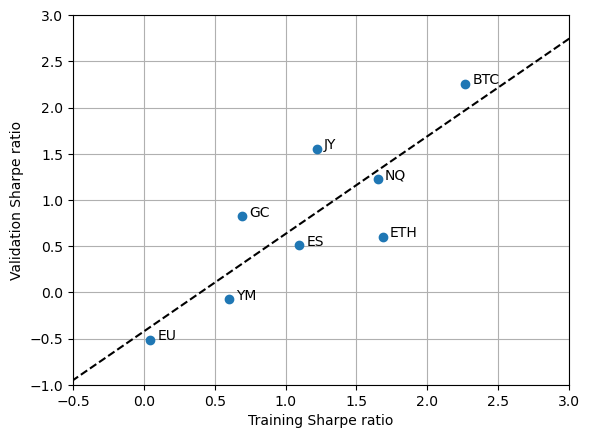

In [ ]:
coef = np.polyfit(os_stats_df['Sharpe ratio IS'], os_stats_df['Sharpe ratio OS'], 1)
poly1d_fn = np.poly1d(coef)

x = [-4, 4]

plt.plot(os_stats_df['Sharpe ratio IS'], os_stats_df['Sharpe ratio OS'], 'o', x, poly1d_fn(x), '--k')
for ticker in tickers:
    plt.annotate(ticker, xy = (os_stats_df.loc[ticker, 'Sharpe ratio IS']+0.05, os_stats_df.loc[ticker, 'Sharpe ratio OS']))
plt.grid()
plt.xlabel('Training Sharpe ratio')
plt.ylabel('Validation Sharpe ratio')

plt.xlim(-0.5, 3)
plt.ylim(-1, 3)

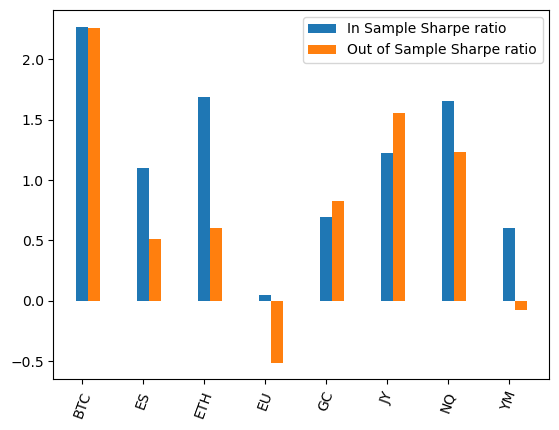

In [ ]:
plt.bar(np.arange(os_stats_df.shape[0]), os_stats_df['Sharpe ratio IS'], width = 0.2, label = 'In Sample Sharpe ratio')
plt.bar(np.arange(os_stats_df.shape[0])+0.2, os_stats_df['Sharpe ratio OS'], width = 0.2, label = 'Out of Sample Sharpe ratio')
plt.legend()
_ = plt.xticks(np.arange(os_stats_df.shape[0]), os_stats_df.index, rotation = 70)

In [ ]:
pnl_train = (1+pnl.dropna().cumsum())[:in_sample_end]

mu = mean_historical_return(pnl_train)
S = CovarianceShrinkage(pnl_train.dropna()).ledoit_wolf()

C:\Users\rkalmetev-gph\AppData\Roaming\Python\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


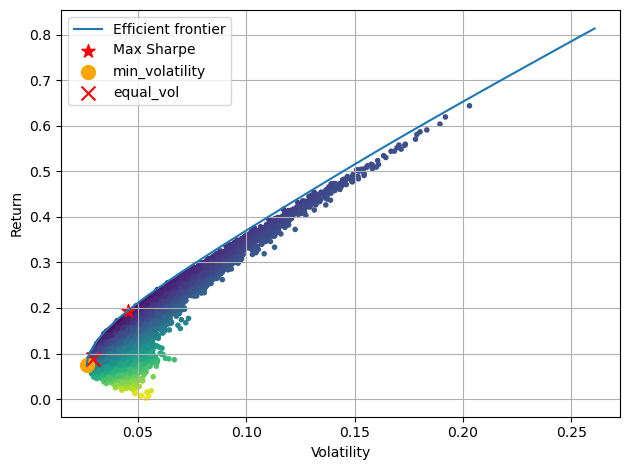

In [ ]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plt.rc('axes', axisbelow = True)
plt.grid()

ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax = ax, show_assets = False)


# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker = ".", c = sharpes, cmap = "viridis_r")


# Find the tangency portfolio
weights_max_sharpe = ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker = "*", s = 100, c = "r", label = "Max Sharpe")


ef_ = EfficientFrontier(mu, S)
ef_min_vol = ef_.deepcopy()
weights_min_vol =  ef_min_vol.min_volatility()
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker = "o", s = 100, c = "orange", label = "min_volatility")

ef_ = EfficientFrontier(mu, S)
ef_min_vol = ef_.deepcopy()
w = 1/os_stats_df['Volatility IS']
w = w/ w.sum()
weights_eq_vol =  w
ef_min_vol.weights = w
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker = "x", s = 100, c = "r", label = "equal_vol")

ax.legend()
plt.tight_layout()

Sharpe ratio = 2.70
Annual Return = 0.19
Annual Std = 0.07


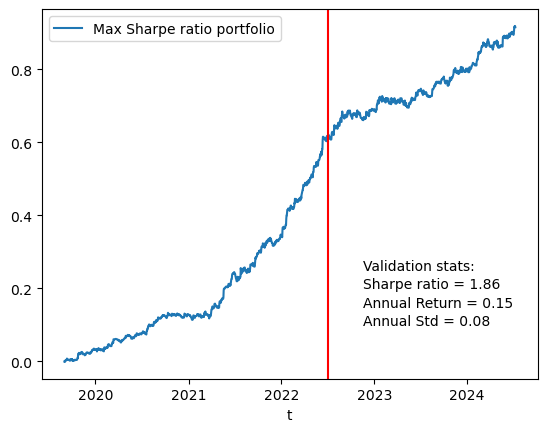

In [ ]:
eq = (pnl*weights_max_sharpe).sum(axis = 1)
_ = statistics_calc(eq, name = 'Max Sharpe ratio portfolio', plot = True)
stats = statistics_calc(eq[in_sample_end:], name = '_', plot = False)

plt.text(eq.index[-600], 0.25, 'Validation stats:')
plt.text(eq.index[-600], 0.2, 'Sharpe ratio = %0.2f'%stats['Sharpe ratio'].iloc[0])
plt.text(eq.index[-600], 0.15, 'Annual Return = %0.2f'%stats['Annual return'].iloc[0])
plt.text(eq.index[-600], 0.1, 'Annual Std = %0.2f'%stats['Volatility'].iloc[0])
plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Sharpe ratio = 2.53
Annual Return = 0.10
Annual Std = 0.04


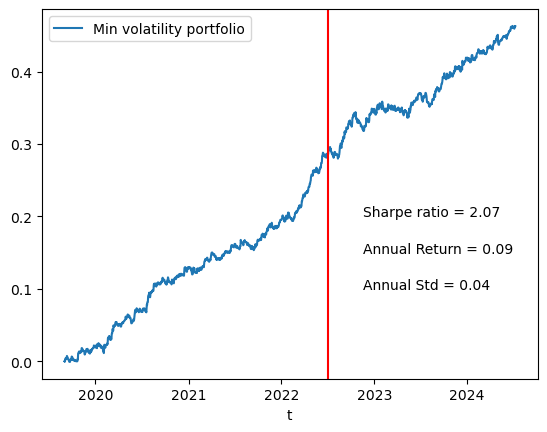

In [ ]:
eq = (pnl*weights_min_vol).sum(axis = 1)
_ = statistics_calc(eq, name = 'Min volatility portfolio', plot = True)
stats = statistics_calc(eq[in_sample_end:], name = '_', plot = False)

plt.text(eq.index[-600], 0.2, 'Sharpe ratio = %0.2f'%stats['Sharpe ratio'].iloc[0])
plt.text(eq.index[-600], 0.15, 'Annual Return = %0.2f'%stats['Annual return'].iloc[0])
plt.text(eq.index[-600], 0.1, 'Annual Std = %0.2f'%stats['Volatility'].iloc[0])
plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Sharpe ratio = 2.57
Annual Return = 0.11
Annual Std = 0.04


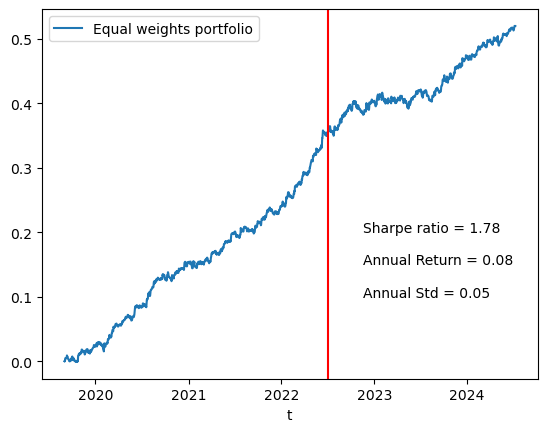

In [ ]:
eq = (pnl*weights_eq_vol).sum(axis = 1)
_ = statistics_calc(eq, name = 'Equal weights portfolio', plot = True)
stats = statistics_calc(eq[in_sample_end:], name = '_', plot = False)

plt.text(eq.index[-600], 0.2, 'Sharpe ratio = %0.2f'%stats['Sharpe ratio'].iloc[0])
plt.text(eq.index[-600], 0.15, 'Annual Return = %0.2f'%stats['Annual return'].iloc[0])
plt.text(eq.index[-600], 0.1, 'Annual Std = %0.2f'%stats['Volatility'].iloc[0])
plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Additional exercises and research topics:

1. Develop and test your own dynamic allocation algorithm that calculates optimal portfolio strategy weights in real time